In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import linregress, pearsonr
from sklearn.datasets import make_friedman1
import seaborn as sns
from sklearn.linear_model import RidgeCV, LassoCV,LinearRegression, ElasticNetCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
from itertools import product
from joblib import Parallel, delayed

FILE_PATTERN = 'data_S2_ols_gM_4_all.csv'
FOLDER = 'equalized'

In [2]:
y_data = pd.read_csv(f'./out/{FOLDER}/y_{FILE_PATTERN}')
y_data.head()

,check_type,target,y,ypred,fold,missing
0,S2,wle_dles,0.723210,0.333806,0,2
1,S2,wle_dles,-0.265638,-0.648419,0,2
2,S2,wle_dles,-0.455612,0.127272,0,1
3,S2,wle_dles,0.053906,0.021078,0,2
4,S2,wle_dles,-0.343468,0.769321,0,2


In [3]:
X_data = pd.read_csv(f'./out/{FOLDER}/X_{FILE_PATTERN}')
print(X_data.shape)
X_data.head()

(4383, 16)


,gender,mother_tongue,frequency,previous_sessions,years_from_start,"('mean', 'dles')","('mean', 'dsif')","('mean', 'ehoe')","('mean', 'eles')","('mean', 'esif')","('mean', 'fhoe')","('mean', 'fles')","('mean', 'fsif')","('mean', 'mfur')","('mean', 'mgfd')","('mean', 'mzuv')"
0,0.0,1.0,1000000.0,0.0,0.0,-0.055132,0.525853,0.775234,0.488993,0.052450,0.346688,-0.800466,0.119779,0.060702,0.279674,0.733133
1,0.0,0.0,1000000.0,0.0,0.0,-0.879871,-0.268844,NaN,0.083740,0.341636,-0.154996,-0.432178,-0.370742,-0.493625,-0.608445,0.132380
2,0.0,1.0,1000000.0,0.0,0.0,0.163896,0.359484,NaN,-0.344985,NaN,-0.842814,-0.701016,-0.821215,-0.556069,-0.582401,-0.491055
3,1.0,1.0,1000000.0,0.0,0.0,0.001762,0.162528,0.199880,-0.812177,-0.776570,-0.558290,-1.781372,-0.986780,-0.476955,-0.022338,-0.083265
4,1.0,1.0,1000000.0,0.0,0.0,1.291564,0.881406,0.281974,0.125706,NaN,-0.808205,-0.616624,NaN,0.193854,0.470873,0.336374


<Axes: >

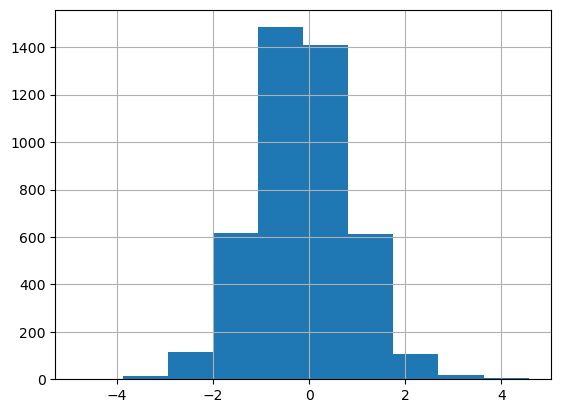

In [4]:
y_data.y.hist()

def sample_uniformly(n, x) {
    bounds = np.array((x.min(), x.max()))
    r = diff(bounds) + 1
    x = c(bounds[1]-r, sort(x), bounds[2]+r) # Place sentinels around `x`
    u <- runif(n, bounds[1], bounds[2])       # Sample range of `bounds`
      #
      # Algorithm to find nearest `x` values to each `u` value.
      #
      a <- c(x, u)
      i <- c(rep(TRUE, length(x)), rep(FALSE, length(u)))[order(a)]
      j <- cumsum(i)[!i]
      k <- length(x) + 1 - rev(cumsum(rev(i)))[!i]
      ifelse(runif(n, a[j], a[k]) > u, a[j], a[k])
}

In [5]:
def sample_uniformly(y, X, nsamples=None, nbins=100):
    
    order = np.argsort(y)
    y_sorted = y[order]
    X_sorted = X[order, :]
    d = (- y_sorted[0] + y_sorted[-1])/1000
    bins = np.linspace(y_sorted[0] - d , y_sorted[-1] + d, nbins)
    
    hist, _ = np.histogram(y_sorted, bins)
    
    if nsamples is None:
        nsamples = np.min(hist)
    sampled_index_list = []
    for i in range(nbins-1):
        indices,  = np.where(np.logical_and(y_sorted >= bins[i], y_sorted <= bins[i+1]))
        #values = order[indices]
        sampled_index_list.append(np.random.choice(indices, np.minimum(nsamples, len(indices)), replace=False))
    
    #print(sampled_index_list)
    #print([ len(x) for x in sampled_index_list])
    sampled_index = np.unique(np.concatenate(sampled_index_list))
    #print(sampled_index)
    y_sampled = y_sorted[sampled_index]
    X_sampled = X_sorted[sampled_index, :]
    return y_sampled, X_sampled

In [6]:
def ensemble_predict(y_train, X_train, y_test, X_test, pipeline, nmodels=5, nsamples=10):
    #if n is None:
    #    n = len(y_train)
    ypred = y_test*0
    for i in range(nmodels):
        y_sampled, X_sampled = sample_uniformly(y_train, X_train, nsamples=nsamples)
        #y_sampled, X_sampled = sample_uniformly(y_train, X_train, n, beta_a)
        pipeline.fit(X_sampled, y_sampled)
        #print(X_sampled.shape)
        #print(X_train.shape)
        #print(X_test.shape)
        ypred_ = pipeline.predict(X_test)
        pipeline.fit(X_train, y_train)
        ypred_all = pipeline.predict(X_test)
        #plt.figure()
        #sns.regplot(x = y_train, y = pipeline.predict(X_train), color = 'red', scatter_kws={'s':1, 'alpha':0.2})
        #sns.regplot(x = y_sampled, y = pipeline.predict(X_sampled), color = 'blue', scatter_kws={'s':1, 'alpha':0.2})
        #sns.regplot(x = y_test, y = ypred_, color = 'red', scatter_kws={'s':1, 'alpha':0.2})
        #sns.regplot(x = y_test, y = ypred_all, color = 'blue', scatter_kws={'s':1, 'alpha':0.2})
        #plt.plot([-3, 3], [-3, 3], color = 'green')
        #print(X_sampled.shape)
        #print(X_train.shape)
        #print(r2_score(y_sampled, pipeline.predict(X_sampled)))
        #print(r2_score(y_train, pipeline.predict(X_train)))
        #print(r2_score(y_test, ypred_))
        #print(r2_score(y_test, ypred_all))
        ypred += ypred_
    # Average predictions of all models
    #print(10*"-")
    ypred /= nmodels
    #print(r2_score(y_train, pipeline.predict(X_train)))
    #print(r2_score(y_test, ypred))
    #print(pearsonr(y_test, ypred))
    return ypred, len(y_sampled)/len(y_train)

model_dict = {
    'ridge':RidgeCV(alphas=np.logspace(-3, 5, 9)),
    'lasso':LassoCV(n_alphas=50),
    'OLS':LinearRegression(),
    'enet':ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], n_alphas=10)
             }

def do_fit(X, nmodels, nsamples, use_RFE=0, model='ridge', noise=0):
    
    importances_list = []
    fold_list = []
    X_list = []
    y_list = []
    mse_list = []
    r2_list = []
    r_list = []
    slope_list = []
    
    lm = model_dict[model]
                
    if use_RFE == 0: 
        pipeline =  Pipeline([
                    ('imputer', IterativeImputer(max_iter=100, random_state=0)),
                    ('scaler', StandardScaler()),
                    ('lm', lm),
                ])
    else:
        selector = RFE(lm, n_features_to_select=use_RFE, step=1)
        pipeline =  Pipeline([
                    ('imputer', IterativeImputer(max_iter=100, random_state=0)),
                    ('scaler', StandardScaler()),
                    ('lm', selector),
                ])
    
    
    for i, (train, test) in enumerate(outer_cv.split(X)):
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]

        #pipeline.fit(X_train, y_train)
        ypred, rel_size = ensemble_predict(y_train, X_train, y_test, X_test, pipeline, nmodels, nsamples)
        #ypred = pipeline.predict(X_test)
        r2_list.append(r2_score(y_test, ypred))
        slope_list.append(linregress(y_test, ypred).slope)
        r_list.append(pearsonr(y_test, ypred).statistic)
        mse_list.append(mean_squared_error(y_test, ypred))
        y_list.append((y_test, ypred))
        X_list.append(X_test)
        #importances_list.append(np.abs(pipeline.named_steps['lm'].coef_))
        fold = y_test*0 + i
        fold_list.append(fold.astype(int))

    return rel_size, np.mean(r2_list), np.mean(mse_list), np.mean(r_list), np.mean(slope_list), noise
        

In [7]:
def create_dataset(n_samples, n_features, noise=1, random_state=0, friedman=False):
    
    if friedman:
        X, y = make_friedman1(n_samples=n_samples, n_features=n_features, noise=noise, random_state=random_state)   
    else:
        mean = np.zeros(n_features)
        cov = np.eye(n_features)
        X = np.random.multivariate_normal(mean, cov, size=n_samples)
        beta = np.random.multivariate_normal(mean, cov, size=1)
        epsilon = np.random.normal(0, 1, size=(n_samples, 1))
        y = X@np.transpose(beta) + noise*epsilon
        y = y.flatten()
        
    return X, y

X, y = create_dataset(10, 5, 2)
print(X.shape)
print(y.shape)

(10, 5)
(10,)


In [8]:
n_folds = 3
NJOBS = 30
outer_cv = KFold(n_splits=n_folds, shuffle=True)

y_orig = y_data.y.values
X_orig = X_data.values

if False:
    noises = [0, 1]
    nmodels = [1, 10]
    nsamples = [10, 100]
    use_RFE = [0]
    models = ['ridge', 'OLS']

else:
    noises = [0, 1, 3, 5, 7]
    nmodels = [1, 10, 20, 50]
    nsamples = [10, 50, 100, 200, 300]
    use_RFE = [0] #, 5, 10]
    models = ['ridge', 'OLS', 'lasso'] #, 'enet']

results = []
prods = list(product(nmodels, nsamples, use_RFE, models))        
print(len(prods))

for noise in noises:

    if noise > 0:
        X, y = create_dataset(n_samples=X_orig.shape[0], n_features=X_orig.shape[1], noise=noise, random_state=0)    
    else:
        X, y = X_orig, y_orig
        
    results_partial = Parallel(n_jobs=NJOBS)(delayed(do_fit)(X, p[0], p[1], p[2], p[3], noise) for p in prods)
    results.extend(results_partial)

#print(results) 

#size, r2,  np.mean(mse_list), np.mean(slope_list)
#(X, nmodels, nsamples, use_RFE=False, model='ridge')

60


In [9]:
df1 = pd.DataFrame(results, columns = ['rel_size', 'r2', 'mse', 'r', 'slope', 'noise'])
df2 = pd.DataFrame(prods*len(noises), columns = ['nmodels', 'nsamples', 'use_RFE', 'model'])
df = pd.concat((df1, df2), axis=1)
df.to_csv('./out/simulations.csv')
df.head()

,rel_size,r2,mse,r,slope,noise,nmodels,nsamples,use_RFE,model
0,0.188227,0.144439,0.867939,0.517294,0.442230,0,1,10,0,ridge
1,0.188569,0.082255,0.929097,0.512089,0.469586,0,1,10,0,OLS
2,0.203628,0.091665,0.920604,0.515015,0.469045,0,1,10,0,lasso
3,0.681040,0.259398,0.751266,0.523305,0.334729,0,1,50,0,ridge
4,0.656057,0.255836,0.754107,0.524198,0.341835,0,1,50,0,OLS


<Figure size 640x480 with 0 Axes>

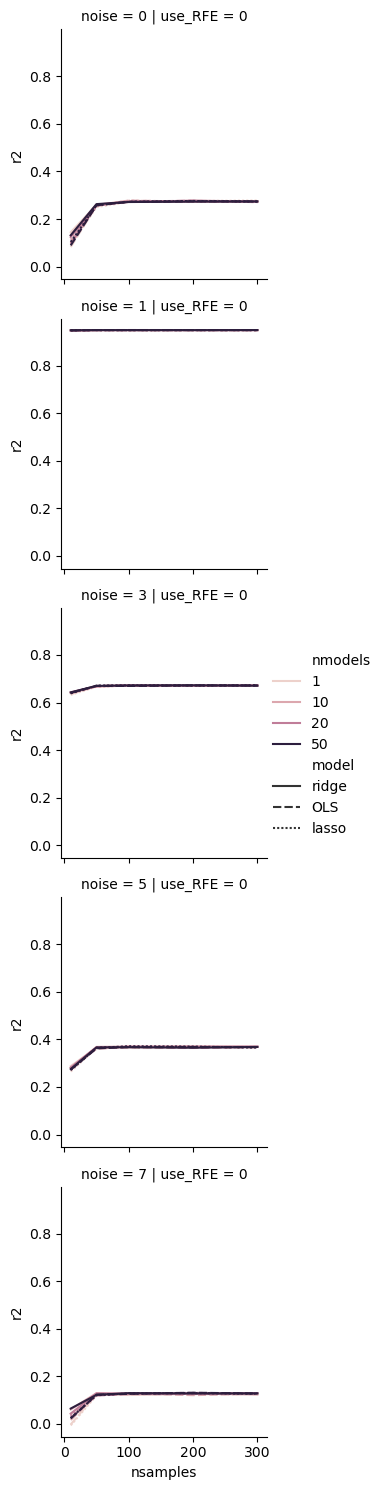

<Figure size 640x480 with 0 Axes>

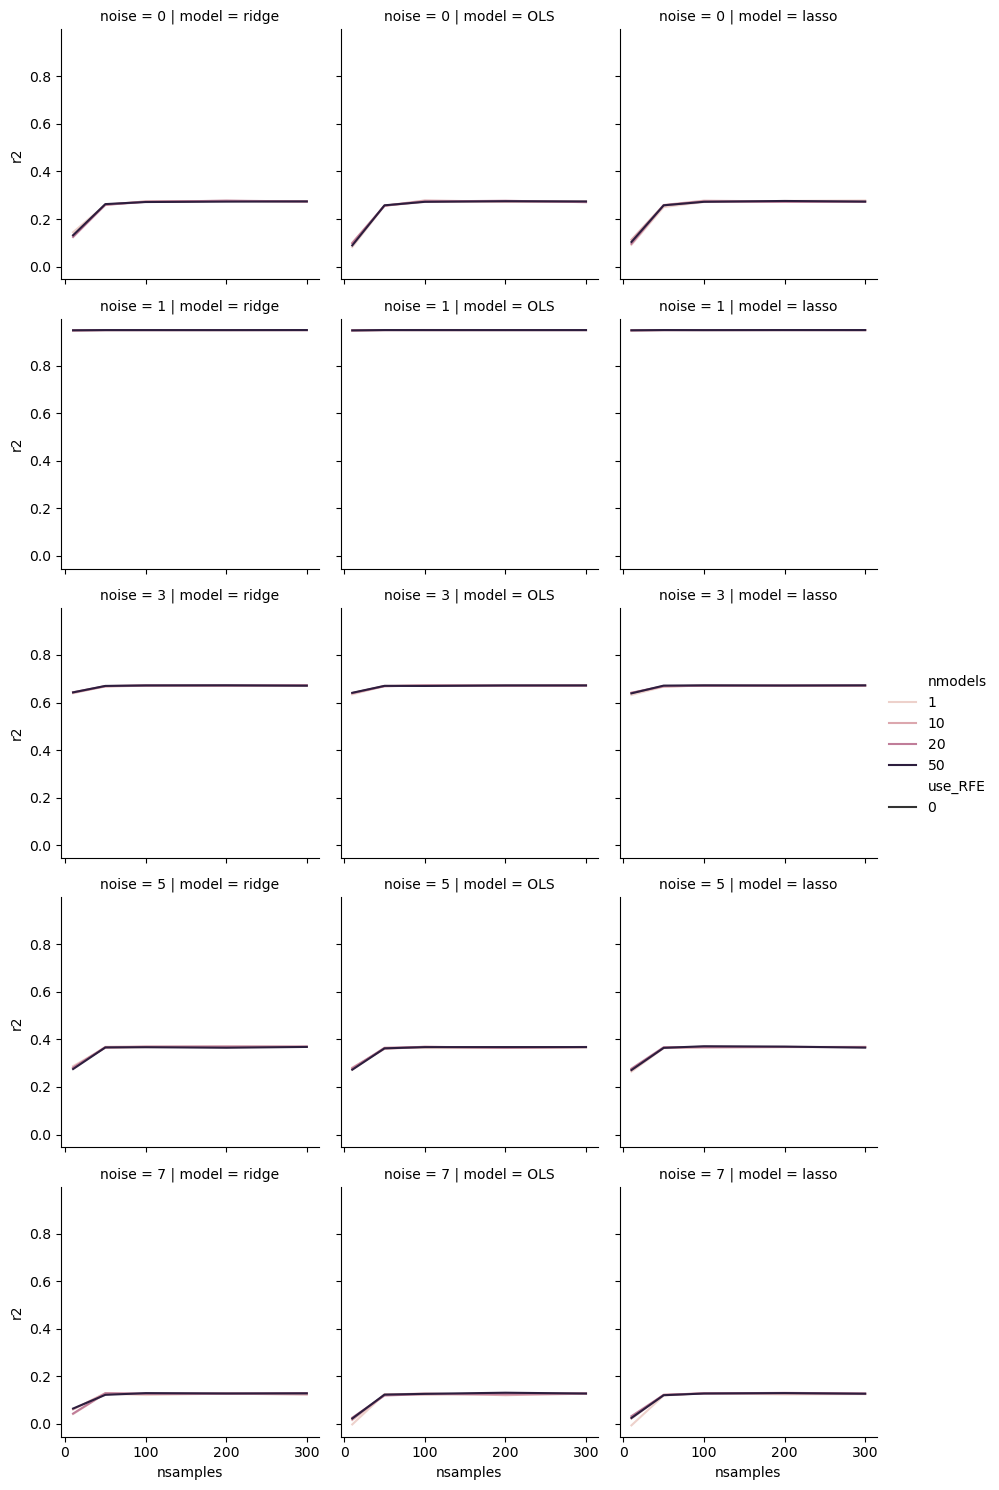

<Figure size 640x480 with 0 Axes>

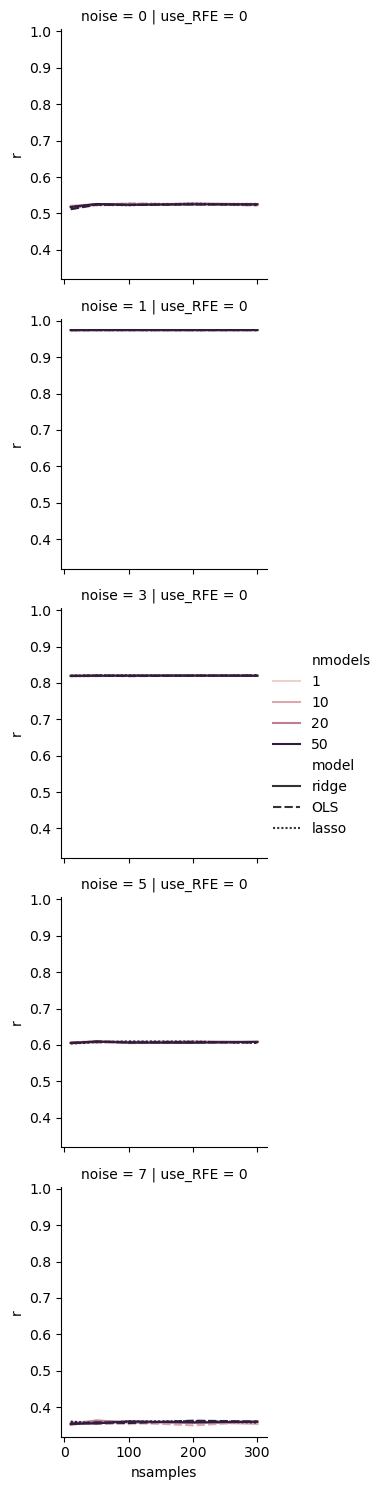

<Figure size 640x480 with 0 Axes>

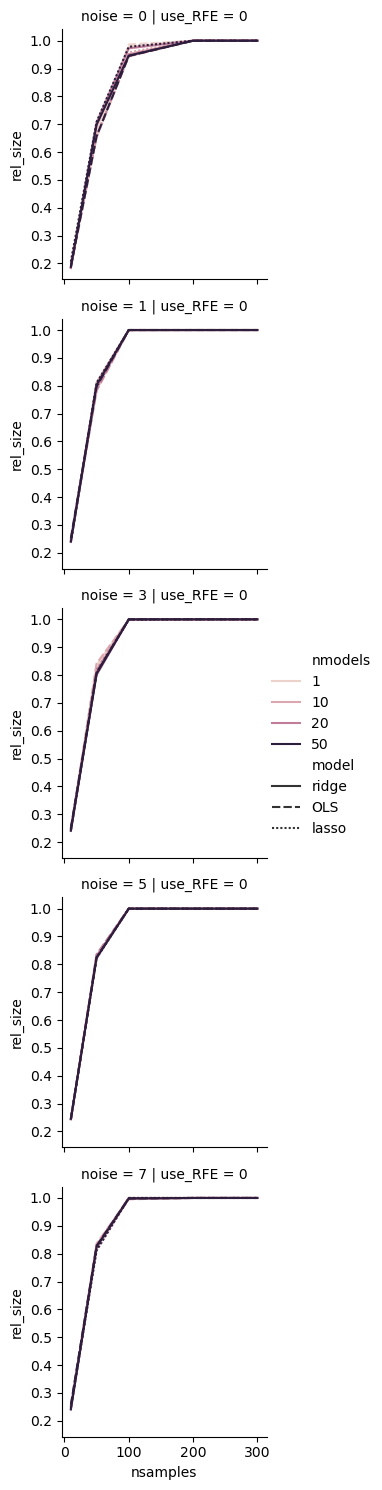

<Figure size 640x480 with 0 Axes>

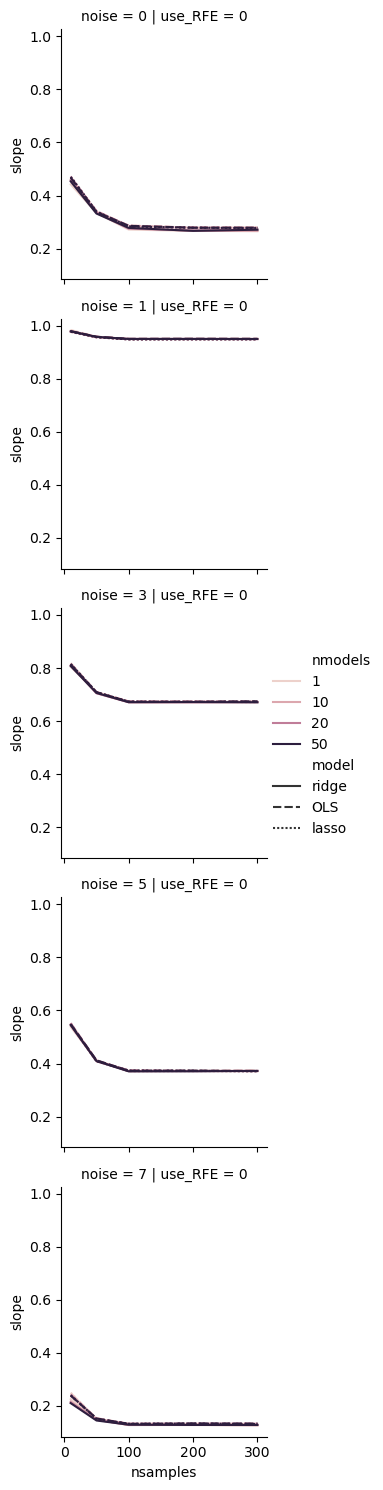

<Figure size 640x480 with 0 Axes>

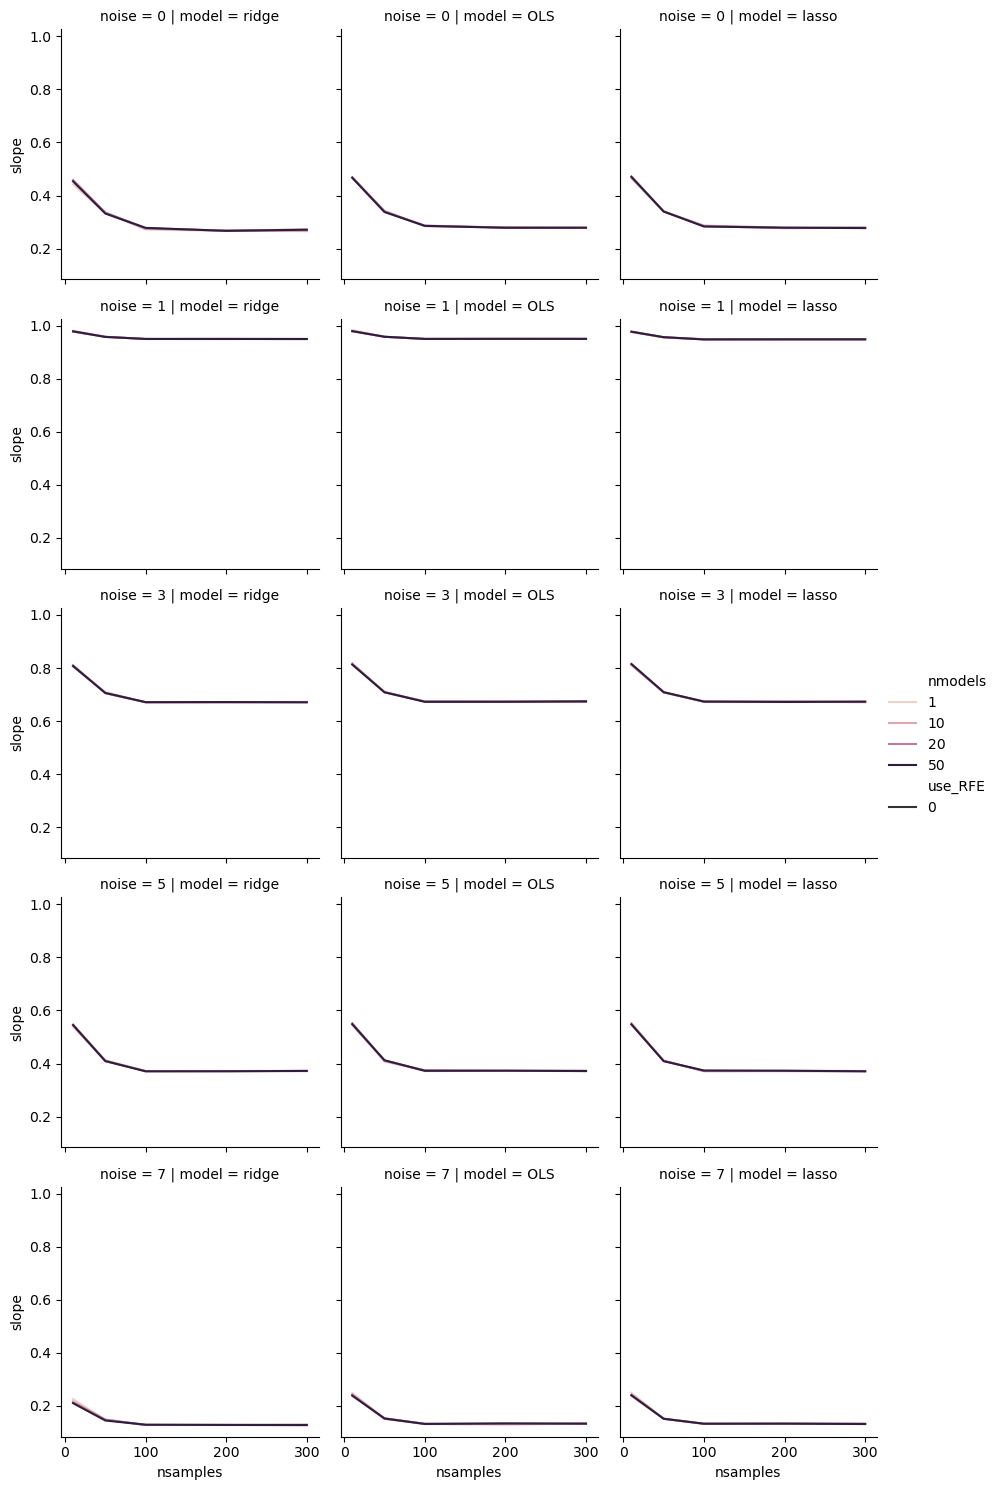

<Figure size 640x480 with 0 Axes>

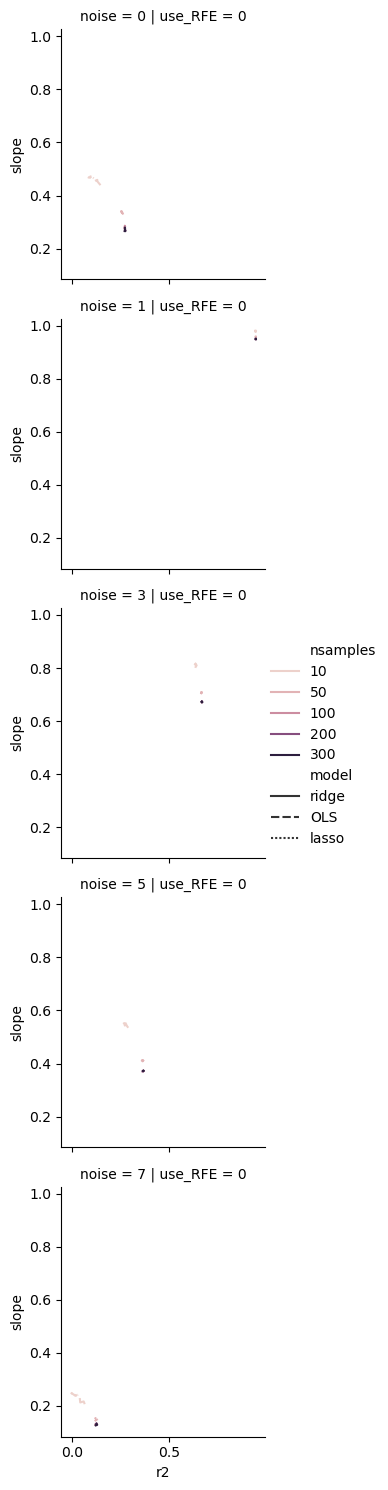

In [10]:
plt.figure()
g = sns.FacetGrid(df, col='use_RFE', row='noise')
g.map_dataframe(sns.lineplot, x='nsamples', y='r2', hue='nmodels', style='model')
g.add_legend()
plt.show()

plt.figure()
g = sns.FacetGrid(df, col='model', row='noise')
g.map_dataframe(sns.lineplot, x='nsamples', y='r2', hue='nmodels', style='use_RFE')
g.add_legend()
plt.show()

plt.figure()
g = sns.FacetGrid(df, col='use_RFE', row='noise')
g.map_dataframe(sns.lineplot, x='nsamples', y='r', hue='nmodels', style='model')
g.add_legend()
plt.show()

plt.figure()
g = sns.FacetGrid(df, col='use_RFE', row='noise')
g.map_dataframe(sns.lineplot, x='nsamples', y='rel_size', hue='nmodels', style='model')
g.add_legend()
plt.show()

plt.figure()
g = sns.FacetGrid(df, col='use_RFE', row='noise')
g.map_dataframe(sns.lineplot, x='nsamples', y='slope', hue='nmodels', style='model')
g.add_legend()
plt.show()

plt.figure()
g = sns.FacetGrid(df, col='model', row='noise')
g.map_dataframe(sns.lineplot, x='nsamples', y='slope', hue='nmodels', style='use_RFE')
g.add_legend()
plt.show()


plt.figure()
g = sns.FacetGrid(df, col='use_RFE', row='noise')
g.map_dataframe(sns.lineplot, x='r2', y='slope', hue='nsamples', style='model')
g.add_legend()
plt.show()


y_test, ypred = zip(*y_list)
y_test = np.concatenate(y_test)
ypred = np.concatenate(ypred)

print(r2_score(y_list[0][0], y_list[0][1]))
print(linregress(y_list[0][0], y_list[0][1]))
print(pearsonr(y_list[0][0], y_list[0][1]))
r2_score(y_test, ypred)
sns.regplot(x = y_list[0][0], y = y_list[0][1], scatter_kws={'s':1, 'alpha':0.2})
plt.plot([-3, 3], [-3, 3])

yt = y_list[0][0]
yp = y_list[0][1]
yminusf2 = (yt - yp)**2
sserr = sum(yminusf2)
mean = float(sum(yt)) / float(len(yt))
yminusmean2 = (yt - mean)**2
sstot = sum(yminusmean2)
R2 = 1. -(sserr / sstot)
print(R2, mean, sstot, sserr)
print(r2_score(yt, yp))
print(np.sqrt(mean_squared_error(yt, yp)))

print(r2_list)

ypred0 = cross_val_predict(pipeline, X, y, cv=n_folds).ravel()

sns.regplot(x = y_test, y = ypred, scatter_kws={'s':1, 'alpha':0.2})
plt.axis('equal')
result = linregress(y_test, ypred)
print(result)

In [11]:
# try nsamples, nmodels, nbins

sns.regplot(x = y, y = ypred0, scatter_kws={'s':1, 'alpha':0.2})
plt.axis('equal')
result = linregress(y, ypred0)
print(result)

len(y)
len(y_test)